<a href="https://colab.research.google.com/github/aryamanpathak2022/VR_Assignment1_ARYAMAN_IMT2022513/blob/main/Q1/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import os
import numpy as np
import cv2

In [27]:
# user input for paths
input_path = input("Enter the path to the input image: ")
output_path = input("Enter the directory to save the processed images: ")


Enter the path to the input image: 1.png
Enter the directory to save the processed images: ./


In [28]:
# Ensures the output path is a directory
if not os.path.isdir(output_path):
    os.makedirs(output_path, exist_ok=True)

# Load the image
image = cv2.imread(input_path)
image2 = image  # Preserve original image

if image is None:
    raise ValueError("Error loading image. Check the file path.")


In [29]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [30]:
# Compute scale factor to resize the image while maintaining aspect ratio
max_dim = max(image.shape[:2])
scale_factor = 1000 / max_dim if max_dim > 1000 else 1.0


In [31]:
# Resize both color and grayscale images
new_size = (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor))
image = cv2.resize(image, new_size)
gray = cv2.resize(gray, new_size)


In [32]:
# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (7, 7), 0)


In [33]:
# Adaptive thresholding for edge detection
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)


In [34]:
# Find contours in the thresholded image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
detected_circles = []

In [35]:
# Detect circular objects based on contour properties
for cnt in contours:
    perimeter = cv2.arcLength(cnt, True)  # Contour perimeter
    area = cv2.contourArea(cnt)  # Contour area

    if perimeter > 0:
        circular = (4 * np.pi * area) / (perimeter ** 2)  # Measure circularity

        # Check if the shape is roughly circular and meets the minimum area condition
        if 0.7 < circular < 1 and area > 450 * (scale_factor ** 2):
            detected_circles.append(cnt)


array([[[153, 165, 165],
        [156, 166, 166],
        [157, 167, 167],
        ...,
        [115, 131, 137],
        [114, 130, 136],
        [113, 130, 133]],

       [[153, 165, 165],
        [157, 167, 167],
        [157, 167, 167],
        ...,
        [116, 133, 136],
        [116, 133, 136],
        [114, 131, 134]],

       [[157, 167, 167],
        [156, 166, 166],
        [158, 167, 167],
        ...,
        [116, 132, 135],
        [115, 132, 135],
        [115, 132, 135]],

       ...,

       [[171, 158, 150],
        [172, 159, 151],
        [173, 160, 152],
        ...,
        [170, 162, 155],
        [169, 161, 154],
        [172, 164, 158]],

       [[173, 160, 152],
        [173, 160, 152],
        [172, 159, 151],
        ...,
        [170, 162, 155],
        [168, 160, 153],
        [170, 163, 158]],

       [[173, 161, 151],
        [172, 159, 149],
        [173, 161, 151],
        ...,
        [171, 163, 156],
        [171, 163, 156],
        [169, 161, 154]]], dtype=uint8)
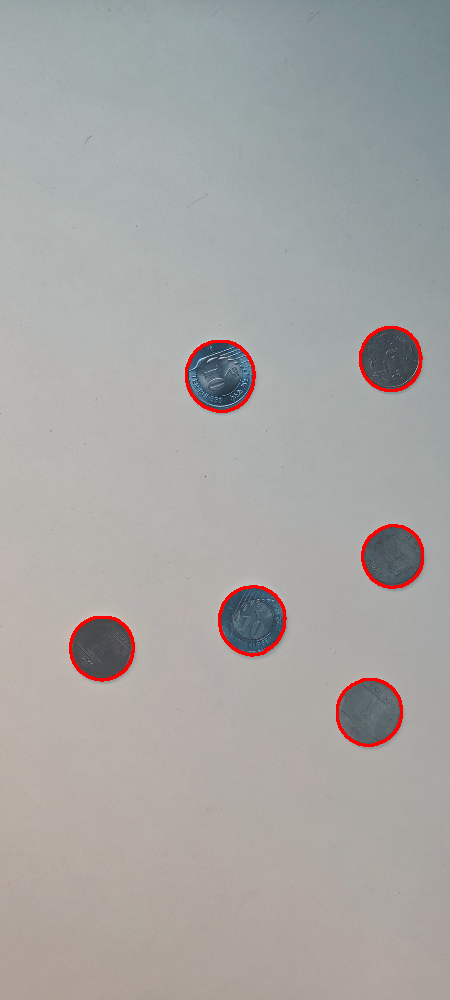

In [36]:
# Draw detected circular contours on a copy of the original image
processed_image = image.copy()
cv2.drawContours(processed_image, detected_circles, -1, (255, 0, 0), 2)


In [37]:
# Save the edges in the image
output_file = os.path.join(output_path, "edges_detected.jpg")
cv2.imwrite(output_file, processed_image)


True

In [38]:
# Create an empty mask for segmentation
mask = np.zeros_like(thresh, dtype=np.uint8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
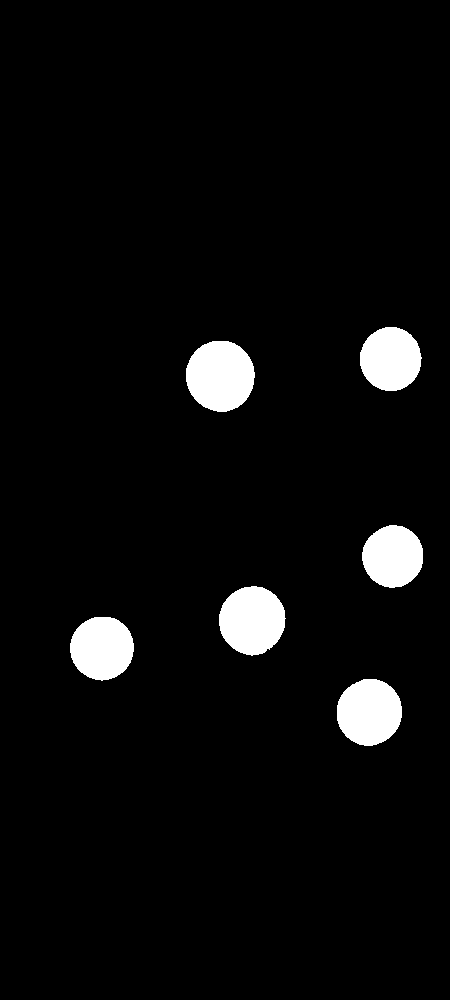

In [39]:
# Draw filled contours (coins) on the mask
cv2.drawContours(mask, detected_circles, -1, 255, thickness=cv2.FILLED)


In [40]:
# Apply mask to the original image to extract coins
segmented = cv2.bitwise_and(image, image, mask=mask)


In [41]:
# Create a black background with the same shape as the image
processed_img = np.zeros_like(image, dtype=np.uint8)

# Overlay segmented coins on the black background
processed_img[mask == 255] = segmented[mask == 255]

# Save the segmented image
output_file = os.path.join(output_path, "segments.jpg")
cv2.imwrite(output_file, processed_img)

True

In [42]:
# Extract individual coin images
segmented_coins = []

for i, cnt in enumerate(detected_circles):
    # Find the minimum enclosing circle for each coin
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    center = (int(x), int(y))
    radius = int(radius)

    # Create a circular mask for extraction
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Apply mask to extract the coin
    coin_segment = cv2.bitwise_and(image, mask)

    # Define cropping coordinates ensuring they stay within image bounds
    x1, y1 = max(center[0] - radius, 0), max(center[1] - radius, 0)
    x2, y2 = min(center[0] + radius, image.shape[1]), min(center[1] + radius, image.shape[0])

    # Crop the extracted coin area
    coin_segment = coin_segment[y1:y2, x1:x2]

    # Append to the list if the cropped image is not empty
    if coin_segment.size > 0:
        segmented_coins.append(coin_segment)


In [43]:
# Save the cropped images of individual coins
if segmented_coins:
    for idx, coin in enumerate(segmented_coins):
        output_file = os.path.join(output_path, f"coin_{idx}.jpg")
        cv2.imwrite(output_file, coin)
        print(f"Saved: {output_file}")
else:
    print("No coins detected or extracted.")

# Count and print the number of detected coins
coin_count = len(segmented_coins)
print(f'{coin_count} coins detected')


Saved: ./coin_0.jpg
Saved: ./coin_1.jpg
Saved: ./coin_2.jpg
Saved: ./coin_3.jpg
Saved: ./coin_4.jpg
Saved: ./coin_5.jpg
6 coins detected
